<a href="https://colab.research.google.com/github/spencer-hann/DeepReinforcementLearning/blob/master/dq_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 8 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (700 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The f

In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1


**OpenAI Gym**

We're gonna spend several next weeks learning algorithms that solve decision processes. We are then in need of some interesting decision problems to test our algorithms.

That's where OpenAI gym comes into play. It's a python library that wraps many classical decision problems including robot control, videogames and board games.

So here's how it works:


In [0]:
import gym
from gym import wrappers

env = gym.make('CartPole-v0').unwrapped
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
env.close()



In [5]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="720" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))


reset() - reset environment to initial state, return first observation

render() - show current environment state (a more colorful version :) )

step(a) - commit action a and return (new observation, reward, is done, info)


In [0]:
import gym
from gym import wrappers
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from math import exp

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, "./gym-results", force=True).unwrapped
env.reset()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv_drop = nn.Dropout2d(p=0.05)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv_drop(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.conv_drop(x)
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

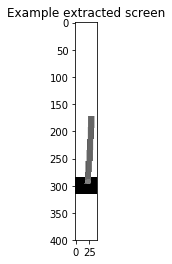

In [9]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((400,40), interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def f(x):
    if x == 255:
        return 1
    return 0
f = np.vectorize(f)

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen.min(axis=0)
#     screen = f(screen)
    # Cart is in the lower half, so strip off the top and bottom of the screen
    screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    screen = resize(screen).unsqueeze(0).to(device)
    return screen

env.reset()
plt.figure()
img = get_screen().cpu().squeeze(0).squeeze(0).numpy()
plt.imshow(img, interpolation='none', cmap="gray")
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 32
GAMMA = 0.999
EPS_START = .999
EPS_END = 0.1
EPS_DECAY = 2500
TARGET_UPDATE = 10

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(),lr=0.0001)#, weight_decay=0.0001
memory = ReplayMemory(10_000)


steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.grid()

#     plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
        #display.clear_output(wait=True)
        #display.display(plt.gcf())

In [0]:
thresholds = []
episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy(), label="durations")
    plt.plot(np.array(thresholds)*100, label="epsilon")
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy(), label="mean")
    plt.grid(); plt.legend()

#     plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
        #display.clear_output(wait=True)
        #display.display(plt.gcf())

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [13]:
from tqdm import tqdm

num_episodes = 1000
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    
    if i_episode > num_episodes * .5:
        EPS_END = 0    
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done or t > 400:
            episode_durations.append(t + 1)
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                exp(-1. * steps_done / EPS_DECAY)
            thresholds.append(eps_threshold)
            break
    if (i_episode+1) % 50 == 0:
        episode_durations_mean = np.mean(episode_durations[-100:])
        print(' Mean last 50:', episode_durations_mean,'\t',np.mean(thresholds[-50:]))
        if episode_durations_mean > 100:
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

  5%|▌         | 50/1000 [00:16<05:17,  2.99it/s]

 Mean last 50: 26.54 	 0.7993290620344751


 10%|█         | 100/1000 [00:31<04:07,  3.63it/s]

 Mean last 50: 24.61 	 0.5211091950127972


 15%|█▌        | 150/1000 [00:44<04:12,  3.37it/s]

 Mean last 50: 21.43 	 0.3750178051240915


 20%|██        | 200/1000 [01:00<03:38,  3.66it/s]

 Mean last 50: 21.78 	 0.2769513568737887


 25%|██▌       | 251/1000 [01:12<04:20,  2.88it/s]

 Mean last 50: 20.91 	 0.21881886671515727


 30%|███       | 301/1000 [01:26<03:13,  3.61it/s]

 Mean last 50: 20.24 	 0.17888932603069904


 35%|███▌      | 350/1000 [01:44<02:16,  4.77it/s]

 Mean last 50: 24.55 	 0.1471648171673686


 40%|████      | 401/1000 [02:05<03:17,  3.04it/s]

 Mean last 50: 29.95 	 0.1265730076423972


 45%|████▌     | 450/1000 [02:23<02:56,  3.11it/s]

 Mean last 50: 30.79 	 0.11434108456265182


 50%|█████     | 500/1000 [02:44<05:22,  1.55it/s]

 Mean last 50: 30.3 	 0.1079213597264672


 55%|█████▌    | 551/1000 [03:06<02:18,  3.24it/s]

 Mean last 50: 32.58 	 0.006486965632830426


 60%|██████    | 601/1000 [03:32<02:35,  2.56it/s]

 Mean last 50: 36.51 	 0.002218884750561778


 65%|██████▌   | 650/1000 [03:55<02:40,  2.18it/s]

 Mean last 50: 38.29 	 0.0010298224044949247


 70%|███████   | 700/1000 [04:24<03:04,  1.63it/s]

 Mean last 50: 40.61 	 0.0004504120625258825


 75%|███████▌  | 750/1000 [04:54<03:56,  1.06it/s]

 Mean last 50: 45.2 	 0.00018903385266292008


 80%|████████  | 800/1000 [05:30<02:52,  1.16it/s]

 Mean last 50: 51.1 	 6.858386668397584e-05


 85%|████████▌ | 850/1000 [06:09<02:14,  1.12it/s]

 Mean last 50: 59.07 	 2.1087014137569235e-05


 90%|█████████ | 900/1000 [06:44<00:59,  1.68it/s]

 Mean last 50: 58.45 	 6.519098648048357e-06


 95%|█████████▌| 950/1000 [07:17<00:33,  1.49it/s]

 Mean last 50: 53.1 	 2.1980108878033343e-06


100%|██████████| 1000/1000 [08:00<00:00,  1.17it/s]

 Mean last 50: 59.11 	 6.962703372384033e-07
Complete


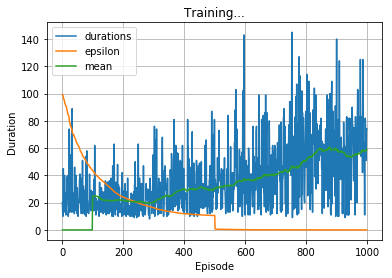

env.length= 0.5
mean: 59.11
max: 145


In [14]:
env.render()
env.close()
plt.ioff()
plot_durations()
plt.show()
print('env.length=',env.length)
print('mean:',np.mean(episode_durations[-100:]))
print('max:', max(episode_durations))

In [15]:
policy_net.eval()

DQN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_drop): Dropout2d(p=0.05)
  (head): Linear(in_features=3008, out_features=2, bias=True)
)

In [16]:
from tqdm import tqdm

thresholds = []
episode_durations = []

env.length = .6

num_episodes = 400
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        #reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        #memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        #optimize_model()
        if done or t > 400:
            episode_durations.append(t + 1)
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                exp(-1. * steps_done / EPS_DECAY)
            thresholds.append(eps_threshold)
            #plot_durations()
            break
    if (i_episode+1) % 50 == 0:
        print(' Mean last 50:', np.mean(episode_durations[-100:]),'\t',np.mean(thresholds[-50:]))
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

 12%|█▎        | 50/400 [00:26<02:36,  2.24it/s]

 Mean last 50: 78.28 	 1.657830087250854e-07


 25%|██▌       | 100/400 [00:54<03:17,  1.52it/s]

 Mean last 50: 82.63 	 3.252306577758726e-08


 38%|███▊      | 150/400 [01:18<01:11,  3.51it/s]

 Mean last 50: 79.31 	 6.398966059034181e-09


 50%|█████     | 201/400 [01:43<01:15,  2.63it/s]

 Mean last 50: 73.32 	 1.5298443368953042e-09


 62%|██████▎   | 250/400 [02:09<01:21,  1.84it/s]

 Mean last 50: 77.06 	 3.3638987313800556e-10


 75%|███████▌  | 300/400 [02:35<00:36,  2.74it/s]

 Mean last 50: 77.83 	 6.767865775165703e-11


 88%|████████▊ | 350/400 [03:02<00:20,  2.46it/s]

 Mean last 50: 80.4 	 1.3476929826761451e-11


100%|██████████| 400/400 [03:28<00:00,  1.88it/s]

 Mean last 50: 81.05 	 2.7238937365334974e-12
Complete


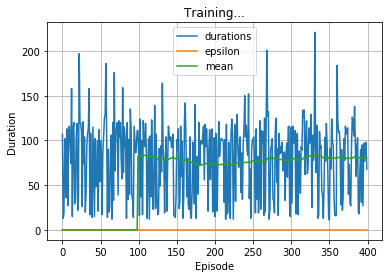

env.length= 0.6
mean: 81.05
max: 221


In [17]:
env.render()
env.close()
plt.ioff()
plot_durations()
plt.show()
print('env.length=',env.length)
print('mean:',np.mean(episode_durations[-100:]))
print('max:', max(episode_durations))

In [19]:
from tqdm import tqdm

thresholds = []
episode_durations = []

env.length = .4

num_episodes = 400
for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        #reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        #memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        #optimize_model()
        if done or t > 400:
            episode_durations.append(t + 1)
            eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                exp(-1. * steps_done / EPS_DECAY)
            thresholds.append(eps_threshold)
            #plot_durations()
            break
    if (i_episode+1) % 50 == 0:
        print(' Mean last 50:', np.mean(episode_durations[-100:]),'\t',np.mean(thresholds[-50:]))
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

 13%|█▎        | 51/400 [00:05<00:39,  8.85it/s]

 Mean last 50: 15.8 	 9.610125801119055e-13


 25%|██▌       | 101/400 [00:11<00:34,  8.71it/s]

 Mean last 50: 15.94 	 7.023057243255211e-13


 38%|███▊      | 151/400 [00:17<00:28,  8.72it/s]

 Mean last 50: 15.46 	 5.138052405532055e-13


 50%|█████     | 201/400 [00:23<00:24,  8.13it/s]

 Mean last 50: 15.66 	 3.7496000132857424e-13


 63%|██████▎   | 252/400 [00:29<00:17,  8.56it/s]

 Mean last 50: 16.2 	 2.720169424504242e-13


 75%|███████▌  | 300/400 [00:34<00:11,  8.51it/s]

 Mean last 50: 15.5 	 1.997294639167921e-13


 88%|████████▊ | 351/400 [00:40<00:05,  8.83it/s]

 Mean last 50: 15.19 	 1.4675254369785045e-13


100%|██████████| 400/400 [00:46<00:00,  8.69it/s]

 Mean last 50: 15.86 	 1.0647897621438832e-13
Complete


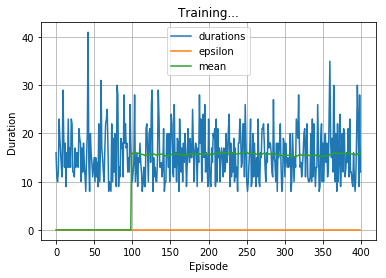

env.length= 0.4
mean: 15.86
max: 41


In [20]:
env.render()
env.close()
plt.ioff()
plot_durations()
plt.show()
print('env.length=',env.length)
print('mean:',np.mean(episode_durations[-100:]))
print('max:', max(episode_durations))